In [2]:
import numpy as np
import matplotlib.pyplot as plt
import glob

from deepposekit import TrainingGenerator
from deepposekit.augment import FlipAxis
import imgaug.augmenters as iaa
import imgaug as ia

from deepposekit.models import (StackedDenseNet,
                                DeepLabCut,
                                StackedHourglass)
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from deepposekit.callbacks import Logger, ModelCheckpoint

import time
from os.path import expanduser
HOME = expanduser("~")

Using TensorFlow backend.


In [3]:
annotations = sorted(glob.glob(HOME + '/deepposekit-data/datasets/fly/*.h5'))
annotations

['/home/jake/deepposekit-data/datasets/fly/annotation_data_release.h5',
 '/home/jake/deepposekit-data/datasets/fly/best_model_fly_densenet.h5',
 '/home/jake/deepposekit-data/datasets/fly/example_annotation_set.h5',
 '/home/jake/deepposekit-data/datasets/fly/log_fly_densenet.h5']

# Create an augmentation pipeline
DeepPoseKit works with augmenters from the [imgaug package](https://github.com/aleju/imgaug).
This is a short example using spatial augmentations with axis flipping and affine transforms
See https://github.com/aleju/imgaug for more documentation on augmenters.


In [4]:
augmenter = []

# FlipAxis only works if the data are rotationally aligned on the central body axis
augmenter.append(FlipAxis(annotations[0], axis=0))  # flip image up-down
augmenter.append(FlipAxis(annotations[0], axis=1))  # flip image left-right 

sometimes = []
sometimes.append(iaa.Affine(scale={"x": (0.95, 1.05), "y": (0.95, 1.05)},
                            translate_percent={'x': (-0.05, 0.05), 'y': (-0.05, 0.05)},
                            shear=(-8, 8),
                            order=ia.ALL,
                            cval=ia.ALL,
                            mode=ia.ALL)
                 )
sometimes.append(iaa.Affine(scale=(0.8, 1.2),
                            mode=ia.ALL,
                            order=ia.ALL,
                            cval=ia.ALL)
                 )
augmenter.append(iaa.Sometimes(0.75, sometimes))
augmenter.append(iaa.Affine(rotate=(-180, 180),
                            mode=ia.ALL,
                            order=ia.ALL,
                            cval=ia.ALL)
                 )
augmenter = iaa.Sequential(augmenter)


# Create a training data generator
This creates a data generator for training the model with annotated data.

In [5]:
train_generator = TrainingGenerator(annotations[0],
                                    downsample_factor=2,
                                    augmenter=augmenter,
                                    sigma=5,
                                    validation_split=0.1,
                                    use_graph=True,
                                    random_seed=1,
                                    graph_scale=0.1)
train_generator.get_config()

{'shuffle': True,
 'downsample_factor': 2,
 'sigma': 5,
 'use_graph': True,
 'graph_scale': 0.1,
 'validation_split': 0.1,
 'datapath': '/home/jake/deepposekit-data/datasets/fly/annotation_data_release.h5',
 'dataset': 'images',
 'output_shape': (48, 48),
 'n_validation': 150,
 'random_seed': 1,
 'n_output_channels': 66,
 'augmenter': True,
 'n_keypoints': 32}

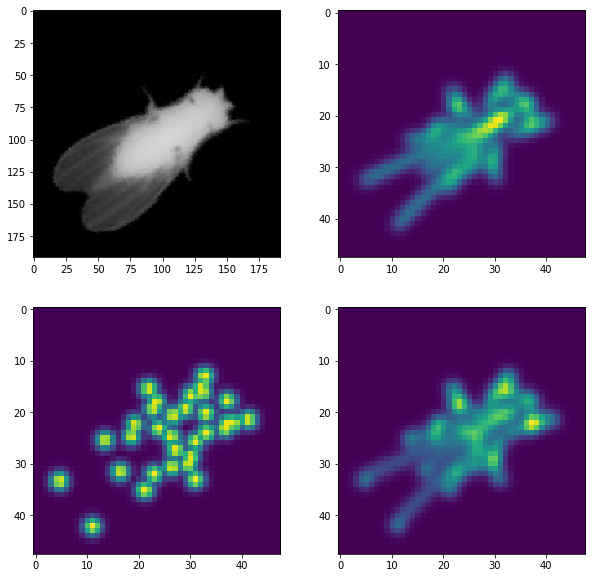

In [6]:
# plot the training data, rerun this cell to see augmentations
n_keypoints = train_generator.n_keypoints
batch = train_generator(batch_size=1, validation=False)[0]
inputs = batch[0]
outputs = batch[1]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.imshow(inputs[0,...,0], cmap='gray', vmin=0, vmax=255)
ax2.imshow(outputs[0,...,n_keypoints:-1].max(-1))
ax3.imshow(outputs[0,...,:n_keypoints].max(-1))
ax4.imshow(outputs[0,...,-1], vmin=0)
plt.show()

train_generator.on_epoch_end()

# Define a model

In [7]:
model = StackedDenseNet(data_generator=train_generator, n_stacks=2)
# model = DeepLabCut(train_generator)
model.compile('adam', 'mse')
model.get_config()

{'name': 'StackedDenseNet',
 'n_stacks': 2,
 'n_layers': 1,
 'n_transitions': 5,
 'growth_rate': 48,
 'bottleneck_factor': 1,
 'compression_factor': 0.5,
 'batchnorm': False,
 'use_bias': True,
 'activation': 'selu',
 'pooling': 'max',
 'interpolation': 'subpixel',
 'subpixel': True,
 'initializer': 'glorot_uniform',
 'separable': False,
 'squeeze_excite': False,
 'shuffle': True,
 'downsample_factor': 2,
 'sigma': 5,
 'use_graph': True,
 'graph_scale': 0.1,
 'validation_split': 0.1,
 'datapath': '/home/jake/deepposekit-data/datasets/fly/annotation_data_release.h5',
 'dataset': 'images',
 'output_shape': (48, 48),
 'n_validation': 150,
 'random_seed': 1,
 'n_output_channels': 66,
 'augmenter': True,
 'n_keypoints': 32}

In [8]:
model.train_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 192, 192, 1)  0                                            
__________________________________________________________________________________________________
float_1 (Float)                 (None, 192, 192, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
image_normalization_1 (ImageNor (None, 192, 192, 1)  0           float_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 96, 48)   2400        image_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [9]:
# Test the prediction speed
x = np.random.randint(0, 255, (10000, 192, 192, 1), dtype='uint8')
model.predict(x[:100], batch_size=100)
t0 = time.time()
y = model.predict(x, batch_size=100, verbose=1)
t1 = time.time()
print(x.shape[0]/(t1-t0))

10000/10000 [==============================] - 17s 2ms/step
594.816896748916


# Define callbacks to enhance model training

In [10]:
logger = Logger(HOME + '/deepposekit-data/datasets/fly/log_densenet.h5',
                batch_size=10)
reduce_lr = ReduceLROnPlateau('val_loss',
                              factor=0.2,
                              verbose=1)
model_checkpoint = ModelCheckpoint(HOME + '/deepposekit-data/datasets/fly/best_model_densenet.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   optimizer=False)
early_stop = EarlyStopping('val_loss',
                           min_delta=0.001,
                           patience=50,
                           verbose=1)
callbacks = [logger, early_stop, reduce_lr, model_checkpoint]

# Fit the model

In [11]:
model.fit(batch_size=16,
          validation_batch_size=10,
          callbacks=callbacks,
          epochs=1000,
          n_workers=8)

Epoch 1/1000
84/84 [==============================] - 45s 540ms/step - loss: 141.5929 - output_0_loss: 71.9562 - output_1_loss: 69.6367 - val_loss: 127.7636 - val_output_0_loss: 65.9062 - val_output_1_loss: 61.8574
evaluation_metrics: mean median (2.5%, 97.5%) - euclidean: 20.8619 13.9248 (1.5311, 74.3796) - mae: 12.8411 9.3500 (0.9800, 45.2200) - mse: 410.8777 97.0960 (1.1721, 2766.1602) - rmse: 14.7516 9.8464 (1.0826, 52.5943)

Epoch 00001: val_loss improved from inf to 127.76356, saving model to /home/jake/deepposekit-data/datasets/fly/best_model_fly_densenet.h5
Epoch 2/1000
84/84 [==============================] - 35s 411ms/step - loss: 123.4802 - output_0_loss: 65.3742 - output_1_loss: 58.1060 - val_loss: 114.6841 - val_output_0_loss: 63.1798 - val_output_1_loss: 51.5043
evaluation_metrics: mean median (2.5%, 97.5%) - euclidean: 20.0451 14.3249 (1.0671, 72.1541) - mae: 11.5309 9.2665 (0.6600, 40.3005) - mse: 414.4482 103.0886 (0.5694, 2603.1043) - rmse: 14.1740 10.1292 (0.7546, 51